<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Predicting West Nile Virus in Chicago

By Amira, Joshua, Joseph, Nelson, Zhi Hong (DSI-28)

---
# Problem Statement

---
# Structure

To organise our work better, we have organised this project into two notebooks: 

* Notebook 1 : Data Cleaning & Exploratory Data Analysis
* Notebook 2 : Feature Engineering, Modelling & Model Evaluation

<span style='color:red'>**This is Notebook 2.**</span>

In [1]:
# import required libraries/packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import radians, sin, cos, sqrt, asin

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import XGBRFClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix, f1_score, roc_auc_score, plot_roc_curve, roc_curve, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm

from IPython.display import Image
from IPython.core.display import HTML 

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore',category=Warning)
warnings.filterwarnings('ignore',category=UserWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.filterwarnings('ignore',category=SyntaxWarning)
warnings.filterwarnings('ignore',category=RuntimeWarning)
warnings.filterwarnings('ignore',category=PendingDeprecationWarning)
warnings.filterwarnings('ignore',category=ImportWarning)
warnings.filterwarnings('ignore',category=UnicodeWarning)
warnings.filterwarnings('ignore',category=BytesWarning)
warnings.filterwarnings('ignore',category=ResourceWarning)
pd.set_option('display.max_rows', 500)

# <font color='Navy'>Importing Data</font>

In [3]:
# load kaggle datasets

train = pd.read_csv('df_train.csv')
test = pd.read_csv('df_test.csv')
weather = pd.read_csv('df_weather.csv')

# <font color='Navy'>Features Engineering</font>

### Building Lagged Features

In [4]:
#build lagged weather features 

days = [1, 3, 5, 8, 12]

def buildLaggedFeatures(df, lag): 
    new_dict={}
    for col_name in df:
        new_dict[col_name]=df[col_name]
        # create lagged Series
        for l in lag:
            if col_name!='Date' and col_name!='Station':
                new_dict['%s_lag%d' %(col_name,l)]=df[col_name].shift(l)
    res=pd.DataFrame(new_dict,index=df.index)
    return res

weather1 = buildLaggedFeatures(weather[weather['Station']==1], days) 
weather2 = buildLaggedFeatures(weather[weather['Station']==2], days) 
weather = weather1.append(weather2)                       
weather.sort_values(['Date', 'Station'], axis=0, ascending=True, inplace=True)
weather = weather.dropna()#  <h1 style="background-color:powderblue;">Data Cleaning & Exploratory Data Analysis</h1>

In [5]:
#Merge Train with weather dataset
df_train_merged = train.merge(weather, on=['Date', 'Station'], how='left')
df_test_merged = test.merge(weather, on=['Date', 'Station'], how='left')
df_train_merged.to_csv('df_train_merged_c.csv')
df_test_merged.to_csv('df_test_merged_c.csv')

In [6]:
df_train_merged['Tavg'] = df_train_merged['Tavg'].astype('int64')
df_train_merged['WetBulb'] = df_train_merged['WetBulb'].astype('int64')
df_train_merged['PrecipTotal'] = df_train_merged['PrecipTotal'].astype('float64')
df_train_merged['StnPressure'] = df_train_merged['StnPressure'].astype('float64')
df_train_merged['WetBulb'] = df_train_merged['WetBulb'].astype('int64')
df_train_merged['ResultSpeed'] = df_train_merged['ResultSpeed'].astype('int64')
df_train_merged['ResultDir'] = df_train_merged['ResultDir'].astype('int64')
df_train_merged['AvgSpeed'] = df_train_merged['AvgSpeed'].astype('float64')
df_train_merged['Sunset'] = df_train_merged['Sunset'].astype('int64')
df_train_merged['Sunrise'] = df_train_merged['Sunrise'].astype('int64')
df_train_merged['Heat'] = df_train_merged['Heat'].astype('int64')
df_train_merged['Cool'] = df_train_merged['Cool'].astype('int64')

In [7]:
df_test_merged['Tavg'] = df_test_merged['Tavg'].astype('int64')
df_test_merged['WetBulb'] = df_test_merged['WetBulb'].astype('int64')
df_test_merged['PrecipTotal'] = df_test_merged['PrecipTotal'].astype('float64')
df_test_merged['StnPressure'] = df_test_merged['StnPressure'].astype('float64')
df_test_merged['WetBulb'] = df_test_merged['WetBulb'].astype('int64')
df_test_merged['ResultSpeed'] = df_test_merged['ResultSpeed'].astype('int64')
df_test_merged['ResultDir'] = df_test_merged['ResultDir'].astype('int64')
df_test_merged['AvgSpeed'] = df_test_merged['AvgSpeed'].astype('float64')
df_test_merged['Sunset'] = df_test_merged['Sunset'].astype('int64')
df_test_merged['Sunrise'] = df_test_merged['Sunrise'].astype('int64')
df_test_merged['Heat'] = df_test_merged['Heat'].astype('int64')
df_test_merged['Cool'] = df_test_merged['Cool'].astype('int64')

In [8]:
df_train_merged.drop(['CodeSum', 'Year_y', 'Month_y', 'Day_y', 'NumMosquitos' ], axis =1, inplace = True)
df_test_merged.drop(['Year_y', 'Month_y', 'Day_y'], axis =1, inplace = True)

In [9]:
df_train_merged.drop(['SeaLevel'], axis =1, inplace = True)
df_test_merged.drop(['SeaLevel'], axis =1, inplace = True)

### Creating Relative Humidity

In [10]:
#Function to calculate relative humidity
def farenheit_to_celcius(x):
    c = ((x - 32) * 5.0)/9.0
    return c

def relative_humidity(avg_temp, dew_point):
    a = 17.27
    b = 237.7
    avg_temp = farenheit_to_celcius(avg_temp)
    dew_point = farenheit_to_celcius(dew_point)
    Td_b = dew_point / b
    aT_bT = a*avg_temp / (b+avg_temp)
    ln_rh = Td_b*(a-aT_bT) - aT_bT / (Td_b + 1)
    return np.exp(ln_rh)

df_train_merged['RelHumidity'] = df_train_merged.apply(lambda x: relative_humidity(x['Tavg'], x['DewPoint']), axis=1)
df_test_merged['RelHumidity'] = df_test_merged.apply(lambda x: relative_humidity(x['Tavg'], x['DewPoint']), axis=1)### Building Lagged Features

### Creating Dark Hours

In [11]:
# Function to covert time to the equivalent float representation, i.e. cast hour to integer, minute to decimal
def conv_time_to_float(timee):
    ## Extract the last two digits (as minutes)
    timee /= 100
    min_ = timee % 1
    ### Convert minute to decimal representation
    min_conv = min_ / .6
    
    ## Extract the first two digits (as hours)
    hour_ = round(timee - min_ ,0)
    
    ## Return float representation of the time
    return hour_ + min_conv

df_train_merged['Sunset'] = df_train_merged['Sunset'].apply(lambda x: conv_time_to_float(x))
df_train_merged['Sunrise'] = df_train_merged['Sunrise'].apply(lambda x: conv_time_to_float(x))
df_train_merged['DarkHours'] = 24 - (df_train_merged['Sunset'] - df_train_merged['Sunrise'])
df_train_merged.head(2)### Creating Relative Humidity

,Unnamed: 0_x,Date,Species,Trap,Latitude,Longitude,WnvPresent,Year_x,Month_x,Day_x,...,Month_lag5,Month_lag8,Month_lag12,Day_lag1,Day_lag3,Day_lag5,Day_lag8,Day_lag12,RelHumidity,DarkHours
0,0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,0,2007,5,29,...,5.0,5.0,5.0,28.0,26.0,24.0,21.0,17.0,0.571297,9.066667
1,1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,0,2007,5,29,...,5.0,5.0,5.0,28.0,26.0,24.0,21.0,17.0,0.606740,9.066667


In [12]:
df_test_merged['Sunset'] = df_test_merged['Sunset'].apply(lambda x: conv_time_to_float(x))
df_test_merged['Sunrise'] = df_test_merged['Sunrise'].apply(lambda x: conv_time_to_float(x))
df_test_merged['DarkHours'] = 24 - (df_test_merged['Sunset'] - df_test_merged['Sunrise'])
df_test_merged.head(2)

,Unnamed: 0_x,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,...,Month_lag5,Month_lag8,Month_lag12,Day_lag1,Day_lag3,Day_lag5,Day_lag8,Day_lag12,RelHumidity,DarkHours
0,0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,...,6.0,6.0,5.0,10.0,8.0,6.0,3.0,30.0,0.560118,8.833333
1,1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,...,6.0,6.0,5.0,10.0,8.0,6.0,3.0,30.0,0.560118,8.833333


# <font color='Navy'>Further Data Processing</font>

In [13]:
df_train_merged.drop(['Date'], axis =1, inplace = True)
df_test_merged.drop(['Date'], axis =1, inplace = True)

df_train_merged.to_csv('df_train_combined_features 2.csv')

df_train_merged.drop( columns = ['SeaLevel_lag1', 'SeaLevel_lag3', 'SeaLevel_lag5', 'SeaLevel_lag8',
                                 'SeaLevel_lag12' ], axis =1, inplace = True)

df_test_merged.drop( columns = ['SeaLevel_lag1', 'SeaLevel_lag3', 'SeaLevel_lag5', 'SeaLevel_lag8',
                                 'SeaLevel_lag12' ], axis =1, inplace = True)#  <h1 style="background-color:powderblue;">Features Engineering</h1>

In [14]:
train_df_corr = df_train_merged.corr()
corr_color = train_df_corr.style.background_gradient(cmap='coolwarm').set_precision(2).set_caption("Heat maps for Cleaned train dataset")
display(corr_color)

In [15]:
df_train_merged.columns

Index(['Unnamed: 0_x', 'Species', 'Trap', 'Latitude', 'Longitude',
       'WnvPresent', 'Year_x', 'Month_x', 'Day_x', 'Station',
       ...
       'Month_lag5', 'Month_lag8', 'Month_lag12', 'Day_lag1', 'Day_lag3',
       'Day_lag5', 'Day_lag8', 'Day_lag12', 'RelHumidity', 'DarkHours'],
      dtype='object', length=122)

In [16]:
df_test_merged.columns

Index(['Unnamed: 0_x', 'Id', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude',
       ...
       'Month_lag5', 'Month_lag8', 'Month_lag12', 'Day_lag1', 'Day_lag3',
       'Day_lag5', 'Day_lag8', 'Day_lag12', 'RelHumidity', 'DarkHours'],
      dtype='object', length=128)

In [17]:
df_test_to_align = df_test_merged.drop(['Id', 'Address', 'Block', 'Street', 'AddressNumberAndStreet','AddressAccuracy'], axis = 1)

df_test_to_align.drop(['CodeSum'], axis =1, inplace = True)
df_train_to_align = df_train_merged.drop(['WnvPresent'], axis = 1)

In [18]:
df_train_to_align.columns

Index(['Unnamed: 0_x', 'Species', 'Trap', 'Latitude', 'Longitude', 'Year_x',
       'Month_x', 'Day_x', 'Station', 'Unnamed: 0_y',
       ...
       'Month_lag5', 'Month_lag8', 'Month_lag12', 'Day_lag1', 'Day_lag3',
       'Day_lag5', 'Day_lag8', 'Day_lag12', 'RelHumidity', 'DarkHours'],
      dtype='object', length=121)

In [19]:
df_test_to_align.columns

Index(['Unnamed: 0_x', 'Species', 'Trap', 'Latitude', 'Longitude', 'Year_x',
       'Month_x', 'Day_x', 'Station', 'Unnamed: 0_y',
       ...
       'Month_lag5', 'Month_lag8', 'Month_lag12', 'Day_lag1', 'Day_lag3',
       'Day_lag5', 'Day_lag8', 'Day_lag12', 'RelHumidity', 'DarkHours'],
      dtype='object', length=121)

## One Hot Encoding (Traps & Species)

In [20]:
trapcolumns = ['Trap']

ohe = OneHotEncoder(categories = 'auto', handle_unknown='ignore')
ohetrap = ohe.fit_transform(df_train_merged['Trap'].values.reshape(-1,1))
ohetrap_check = ohetrap.toarray()
ohe_df = pd.DataFrame(ohetrap_check,columns = ohe.get_feature_names(trapcolumns))

speciescolumns = ['Species']

ohespecies = ohe.fit_transform(df_train_merged['Species'].values.reshape(-1,1))
ohespecies_check = ohespecies.toarray()
ohe_species_df = pd.DataFrame(ohespecies_check,columns = ohe.get_feature_names(speciescolumns))

df_train_merged = pd.concat([df_train_merged, ohe_df, ohe_species_df], axis = 1, verify_integrity = True)

ohetraptest = ohe.fit_transform(df_test_merged['Trap'].values.reshape(-1,1))
ohetraptest_check = ohetraptest.toarray()
ohe_test_df = pd.DataFrame(ohetraptest_check,columns = ohe.get_feature_names(trapcolumns))

ohespeciestest = ohe.fit_transform(df_test_merged['Species'].values.reshape(-1,1))
ohespeciestest_check = ohespeciestest.toarray()
ohe_species_test_df = pd.DataFrame(ohespeciestest_check,columns = ohe.get_feature_names(speciescolumns))

df_test_merged = pd.concat([df_test_merged, ohe_test_df, ohe_species_test_df], axis = 1, verify_integrity = True)

df_train_merged.drop(['Species', 'Trap'], axis =1, inplace = True)
df_test_merged.drop(['Species', 'Trap'], axis =1, inplace = True)

df_train_merged.drop(['Tmax', 'Tmin', 'Sunrise', 'Sunset'], axis =1, inplace = True)
df_test_merged.drop(['Tmax', 'Tmin', 'Sunrise', 'Sunset'], axis =1, inplace = True)

df_train_merged.columns

Index(['Unnamed: 0_x', 'Latitude', 'Longitude', 'WnvPresent', 'Year_x',
       'Month_x', 'Day_x', 'Station', 'Unnamed: 0_y', 'Unnamed: 0_lag1',
       ...
       'Trap_T238', 'Trap_T900', 'Trap_T903', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS'],
      dtype='object', length=259)

In [21]:
df_test_merged.drop(['Address','Block','Street','AddressNumberAndStreet', 'AddressAccuracy', 'CodeSum'], axis =1, inplace = True)
df_test_merged.columns

Index(['Unnamed: 0_x', 'Id', 'Latitude', 'Longitude', 'Year_x', 'Month_x',
       'Day_x', 'Station', 'Unnamed: 0_y', 'Unnamed: 0_lag1',
       ...
       'Trap_T900', 'Trap_T903', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS',
       'Species_UNSPECIFIED CULEX'],
      dtype='object', length=273)

In [22]:
df_train_merged.to_csv('df_train_encoded 2.csv')
df_test_merged.to_csv('df_test_encoded 2.csv')

In [23]:
columns_intersection = df_test_merged.columns.intersection(df_train_merged.columns)
print(columns_intersection)

Index(['Unnamed: 0_x', 'Latitude', 'Longitude', 'Year_x', 'Month_x', 'Day_x',
       'Station', 'Unnamed: 0_y', 'Unnamed: 0_lag1', 'Unnamed: 0_lag3',
       ...
       'Trap_T238', 'Trap_T900', 'Trap_T903', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS'],
      dtype='object', length=258)


In [24]:
columns_difference = df_test_merged.columns.difference(df_train_merged.columns)
columns_difference

Index(['Id', 'Species_UNSPECIFIED CULEX', 'Trap_T002A', 'Trap_T002B',
       'Trap_T065A', 'Trap_T090A', 'Trap_T090B', 'Trap_T090C', 'Trap_T128A',
       'Trap_T200A', 'Trap_T200B', 'Trap_T218A', 'Trap_T218B', 'Trap_T218C',
       'Trap_T234'],
      dtype='object')

In [25]:
df_train_merged.columns.difference(df_test_merged.columns)

for newcol in columns_difference:
    df_train_merged[newcol] = 0
    
df_train_merged.drop(['Id'], axis = 1, inplace= True)
df_train_merged.columns

Index(['Unnamed: 0_x', 'Latitude', 'Longitude', 'WnvPresent', 'Year_x',
       'Month_x', 'Day_x', 'Station', 'Unnamed: 0_y', 'Unnamed: 0_lag1',
       ...
       'Trap_T090A', 'Trap_T090B', 'Trap_T090C', 'Trap_T128A', 'Trap_T200A',
       'Trap_T200B', 'Trap_T218A', 'Trap_T218B', 'Trap_T218C', 'Trap_T234'],
      dtype='object', length=273)

In [26]:
df_test_merged.columns

Index(['Unnamed: 0_x', 'Id', 'Latitude', 'Longitude', 'Year_x', 'Month_x',
       'Day_x', 'Station', 'Unnamed: 0_y', 'Unnamed: 0_lag1',
       ...
       'Trap_T900', 'Trap_T903', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS',
       'Species_UNSPECIFIED CULEX'],
      dtype='object', length=273)

In [27]:
df_train_merged.to_csv('df_train_encoded 3.csv')
df_test_merged.to_csv('df_test_encoded 3.csv')

df_train_merged.drop(['CodeSum_lag1', 'CodeSum_lag3', 'CodeSum_lag5','CodeSum_lag8','CodeSum_lag12'], axis =1, inplace = True)
df_test_merged.drop(['CodeSum_lag1', 'CodeSum_lag3', 'CodeSum_lag5','CodeSum_lag8','CodeSum_lag12'], axis =1, inplace = True)

# <font color='Navy'>Modelling</font>

In [28]:
#Function to plot confusion matrix and retrieve test score
def analyse_model_performance(model, X_train_values, y_train_values, X_test_values, y_test_values):
    
    
    # Get predictions
    preds = model.predict(X_test_values)

    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test_values, preds).ravel()

    dict_scores = {'model': str(model.estimator),
                   'cross_val_score': model.best_score_, 
                   'train_auc_score': model.score(X_train_values, y_train_values),
                   'test_auc_score': model.score(X_test_values, y_test_values),
                   'train_accuracy_score': accuracy_score(y_train_values, model.predict(X_train_values)),
                   'test_accuracy_score': accuracy_score(y_test_values, model.predict(X_test_values)),               
                   'sensitivity': tp / (tp + fn),
                   'specificity': tn / (tn + fp)}

    print(f"optimal Parameters: \n{model.best_params_}\n")
    print(f"Cross Validation Score: \n{dict_scores['cross_val_score']}\n")
    print(f"Train AUC Score: \n{dict_scores['train_auc_score']}\n")
    print(f"Test AUC SCore: \n{dict_scores['test_auc_score']}\n")
    print(f"Train Accuracy Score: \n{dict_scores['train_accuracy_score']}\n")
    print(f"Test Accuracy Score: \n{dict_scores['test_accuracy_score']}\n")
    print(f"Sensitivity: \n{dict_scores['sensitivity']}\n")    
    print(f"Specificity: \n{dict_scores['specificity']}\n")

    plt.figure(figsize=(9,9));
    cf = plot_confusion_matrix(model, X_test_values, y_test_values, display_labels=['Present', 'Not Present'], cmap='Blues', values_format='d');
    plt.show();
    
    plt.figure(figsize=(6,6));
    auc = plot_roc_auc_curve(model, X_test, y_test);
    plt.show();
    
    return dict_scores

def plot_roc_auc_curve(model, X_test_values, y_test_values):
    
    y_pred_proba = model.predict_proba(X_test_values)[:,1]
    fpr, tpr, _ = roc_curve(y_test_values,  y_pred_proba)
    auc = roc_auc_score(y_test_values, y_pred_proba)
    
    plt.plot(fpr,tpr,label="data, auc=" + str(round(auc,4)))
    plt.title("ROC Curve")
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.plot(["0", "1"], ["0", "1"], label='baseline', linestyle='--')
    plt.legend(loc=4)
    plt.show()
    
    return auc

def top10_features(model, title):
    feature_imp = model.best_estimator_._final_estimator.feature_importances_

    feature_imp_df = pd.DataFrame(index=X.columns, data=feature_imp, 
                                  columns=['coefficient']).sort_values(by='coefficient', ascending=False).head(10)
    feature_imp_df.rename_axis('features', inplace=True)
    plt.figure(figsize=(12,8))
    sns.barplot(data=feature_imp_df,
                y=feature_imp_df.index, x='coefficient', orient='h', palette='coolwarm')
    plt.xlabel('Coefficient Values')
    plt.ylabel('All Features')
    plt.title('Top 10 Feature Importance')
    
def analyse_model_performances(model, X_train_values, y_train_values, X_test_values, y_test_values):
    
    
    # Get predictions
    preds = model.predict(X_test_values)

    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test_values, preds).ravel()

    dict_scores = {'model': str(model.estimators), 
                   'train_auc_score': model.score(X_train_values, y_train_values),
                   'test_auc_score': model.score(X_test_values, y_test_values),
                   'train_accuracy_score': accuracy_score(y_train_values, model.predict(X_train_values)),
                   'test_accuracy_score': accuracy_score(y_test_values, model.predict(X_test_values)),               
                   'sensitivity': tp / (tp + fn),
                   'specificity': tn / (tn + fp)}

    print(f"Train AUC Score: \n{dict_scores['train_auc_score']}\n")
    print(f"Test AUC SCore: \n{dict_scores['test_auc_score']}\n")
    print(f"Train Accuracy Score: \n{dict_scores['train_accuracy_score']}\n")
    print(f"Test Accuracy Score: \n{dict_scores['test_accuracy_score']}\n")
    print(f"Sensitivity: \n{dict_scores['sensitivity']}\n")    
    print(f"Specificity: \n{dict_scores['specificity']}\n")

    plt.figure(figsize=(9,9));
    cf = plot_confusion_matrix(model, X_test_values, y_test_values, display_labels=['Present', 'Not Present'], cmap='Blues', values_format='d');
    plt.show();
    
    plt.figure(figsize=(6,6));
    auc = plot_roc_auc_curve(model, X_test, y_test);
    plt.show();
    
    return dict_scores

In [29]:
#Modelling (Train Test Split)
X = df_train_merged.drop(columns=['WnvPresent'])
y = df_train_merged[['WnvPresent']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3 ,random_state = 42, stratify= y)

In [30]:
# Scale the features
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [31]:
# Create more datapoints through the use of SMOTE
sm = SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(X_train_sc, y_train)

# Random Forest Classifier


In [32]:
pipe = Pipeline([
        ('rf', RandomForestClassifier() 
        )])

In [33]:
pipe_params = {
    'rf__n_estimators' : [150, 200, 250],  
    'rf__ccp_alpha': [0, 0.01, 0.1],
    'rf__max_depth': [None, 1, 2, 3, 4, 5]}

gs_rf = GridSearchCV(pipe, pipe_params,n_jobs = -1, cv=5, verbose=1, refit='AUC')

In [34]:
gs_rf.fit(X_train_sm, y_train_sm)
gs_rf.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


{'rf__ccp_alpha': 0, 'rf__max_depth': None, 'rf__n_estimators': 200}

In [35]:
preds_train = gs_rf.predict(X_train_sm)
preds_test = gs_rf.predict(X_test_sc)

optimal Parameters: 
{'rf__ccp_alpha': 0, 'rf__max_depth': None, 'rf__n_estimators': 200}

Cross Validation Score: 
0.9766582502610278

Train AUC Score: 
1.0

Test AUC SCore: 
0.9370821863940229

Train Accuracy Score: 
1.0

Test Accuracy Score: 
0.9370821863940229

Sensitivity: 
0.13138686131386862

Specificity: 
0.9829592684954281



<Figure size 648x648 with 0 Axes>

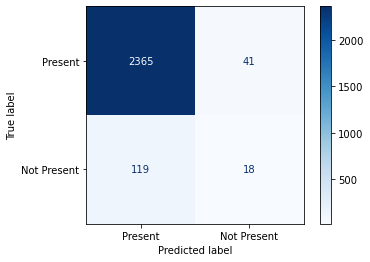

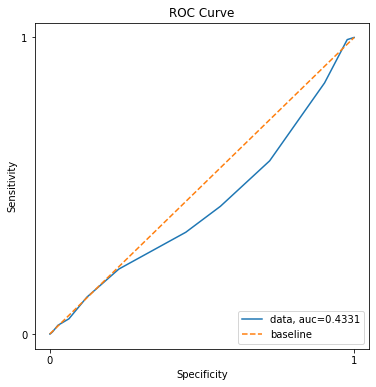

In [53]:
score_dict = {}
score_dict = analyse_model_performance(gs_rf, X_train_sm, y_train_sm, X_test_sc, y_test)
score_dict['model'] ="RandomForestClassifier"
scores = []
scores.append(score_dict)

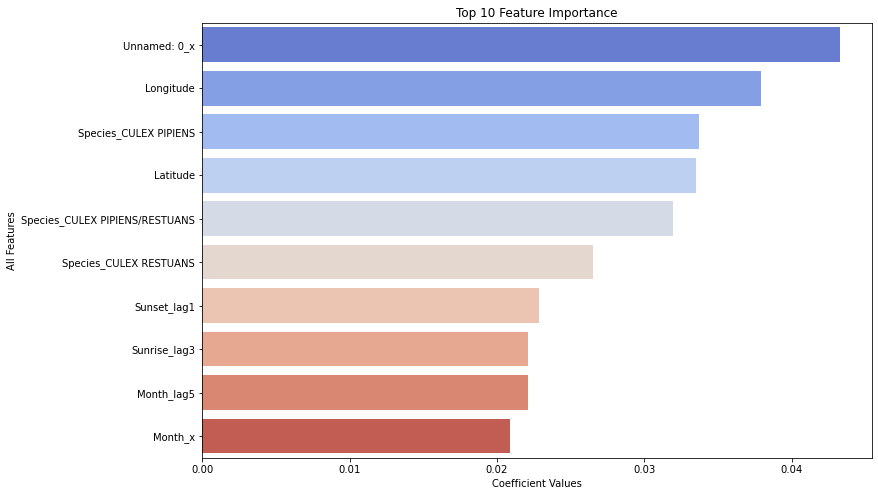

In [37]:
top10_features(gs_rf, 'Feature Importance');

# AdaBoostClassifier


In [38]:
pipe2 = Pipeline([
        ('ada', AdaBoostClassifier(base_estimator=RandomForestClassifier()))])

In [39]:
pipe2_params = {
    'ada__n_estimators': [50,100],
    'ada__base_estimator__max_depth': [1,2,3,5],
    'ada__learning_rate': [.9, 1.]}

gs_ada = GridSearchCV(pipe2, pipe2_params, n_jobs = -1, cv=5, verbose=1, refit='AUC')

gs_ada.fit(X_train_sm, y_train_sm)
gs_ada.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


{'ada__base_estimator__max_depth': 5,
 'ada__learning_rate': 0.9,
 'ada__n_estimators': 50}

In [40]:
preds_train = gs_ada.predict(X_train_sm)
preds_test = gs_ada.predict(X_test_sc)

optimal Parameters: 
{'ada__base_estimator__max_depth': 5, 'ada__learning_rate': 0.9, 'ada__n_estimators': 50}

Cross Validation Score: 
0.971313316579922

Train AUC Score: 
0.9882394868139701

Test AUC SCore: 
0.9406213134093591

Train Accuracy Score: 
0.9882394868139701

Test Accuracy Score: 
0.9406213134093591

Sensitivity: 
0.17518248175182483

Specificity: 
0.9842061512884456



<Figure size 648x648 with 0 Axes>

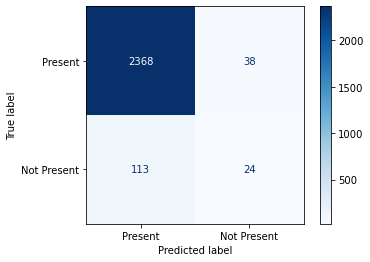

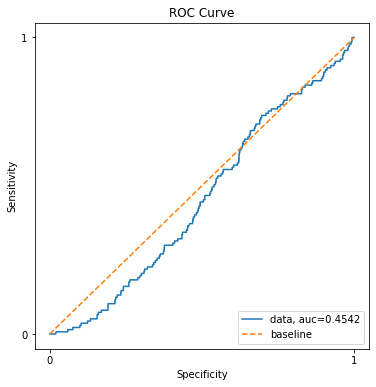

In [54]:
score_dict = analyse_model_performance(gs_ada, X_train_sm, y_train_sm, X_test_sc, y_test)
scores.append(score_dict)
score_dict['model'] ="AdaBoostClassifier"

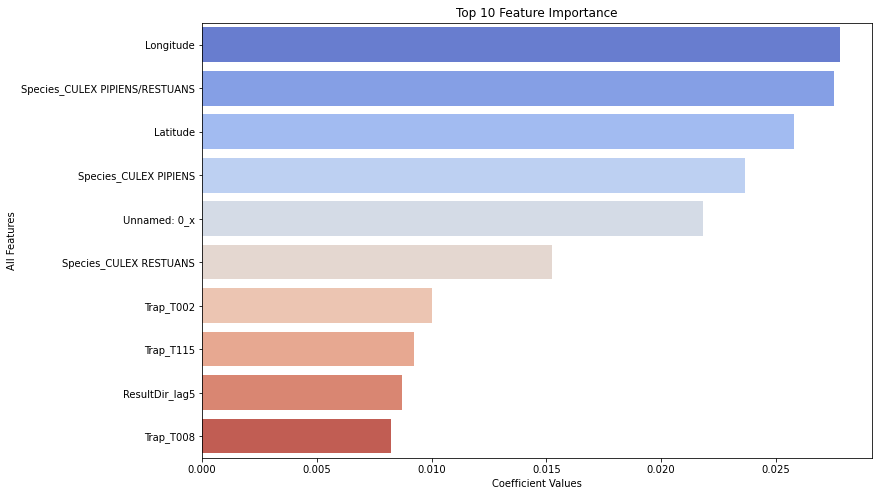

In [42]:
top10_features(gs_ada, 'Feature Importance');

# GradientBoosting Classifier


In [43]:
pipe3 = Pipeline([
        ('gboost', GradientBoostingClassifier())])

In [44]:
pipe3_params = {
    'gboost__n_estimators' : [150, 200, 250],
    'gboost__max_depth': [None, 1, 2, 3],
    'gboost__learning_rate': [.1,.3]}

gs_gboost = GridSearchCV(pipe3, pipe3_params, n_jobs = -1, cv=5, verbose=1, refit='AUC')

gs_gboost.fit(X_train_sm, y_train_sm)
gs_gboost.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'gboost__learning_rate': 0.3,
 'gboost__max_depth': 3,
 'gboost__n_estimators': 200}

In [45]:
preds_train = gs_gboost.predict(X_train_sm)
preds_test = gs_gboost.predict(X_test_sc)

optimal Parameters: 
{'gboost__learning_rate': 0.3, 'gboost__max_depth': 3, 'gboost__n_estimators': 200}

Cross Validation Score: 
0.9615133650139546

Train AUC Score: 
0.9872594440484675

Test AUC SCore: 
0.9347227683837986

Train Accuracy Score: 
0.9872594440484675

Test Accuracy Score: 
0.9347227683837986

Sensitivity: 
0.2116788321167883

Specificity: 
0.9758935993349959



<Figure size 648x648 with 0 Axes>

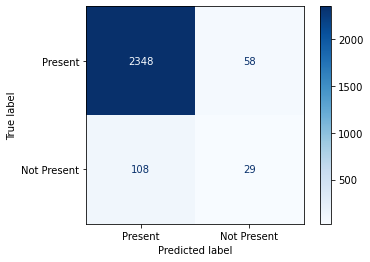

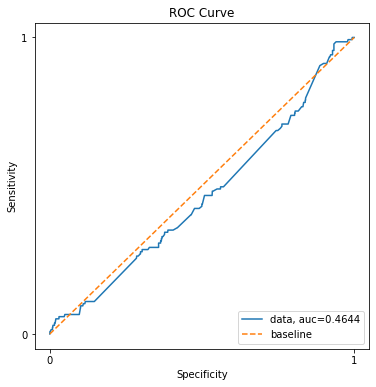

In [55]:
score_dict = analyse_model_performance(gs_gboost, X_train_sm, y_train_sm, X_test_sc, y_test)
scores.append(score_dict)
score_dict['model'] ="GradientBoosting Classifier"

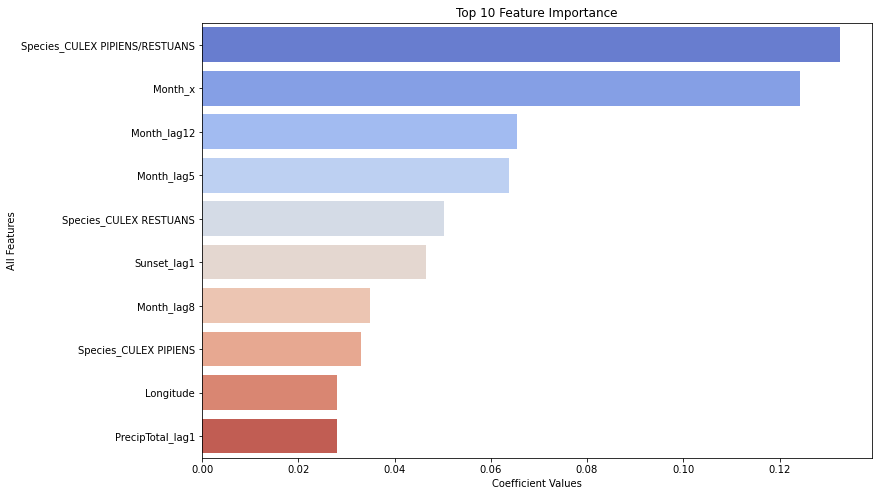

In [47]:
top10_features(gs_gboost, 'Feature Importance');

# Stacking Classifier (XGBClassifier)


{'C': [0.1, 1, 10, 100], 'probability': [True, False]}
Fitting 3 folds for each of 8 candidates, totalling 24 fits
optimal Parameters: 
{'probability': True, 'C': 0.1}

Cross Validation Score: 
0.9460553186723151

Train AUC Score: 
0.9460552933243426

Test AUC SCore: 
0.9461266220998821

Train Accuracy Score: 
0.9460552933243426

Test Accuracy Score: 
0.9461266220998821

Sensitivity: 
0.0

Specificity: 
1.0



<Figure size 648x648 with 0 Axes>

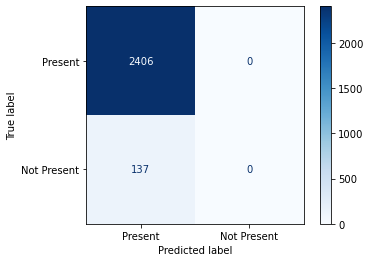

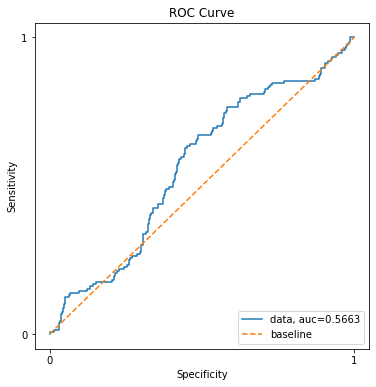

In [58]:
clf1 = XGBClassifier(booster='gbtree', nthread=6, eta=.025, gamma=1.9, max_depth=9, 
                 min_child_weight=6, max_delta_step=0, subsample=0.75, colsample_bytree=0.7, 
                 silent =1, seed=101, l2_reg=1, alpha=0, n_estimators=425)
                  
clf2 = RandomForestClassifier(n_estimators=750, max_depth=9,
                            min_samples_split=2, min_samples_leaf=6, min_weight_fraction_leaf=0.0,
                            max_features=0.75, max_leaf_nodes=None, bootstrap=False, oob_score=False,
                            n_jobs=2, random_state=101, verbose=0, warm_start=False) 

clf3 = ExtraTreesClassifier(n_estimators=850, max_depth=7, min_samples_split=2,
                     min_samples_leaf=5, min_weight_fraction_leaf=0.0, max_features=0.7,
                     max_leaf_nodes=None, bootstrap=False, oob_score=False, n_jobs=2, 
                     random_state=101, verbose=0, warm_start=False)

clf4 = GradientBoostingClassifier(learning_rate=0.015, n_estimators=750, subsample=0.8, 
                                min_samples_split=2, min_samples_leaf=5, min_weight_fraction_leaf=0.0,
                                max_depth=9, init=None, random_state=101, max_features=0.85, verbose=0,
                                max_leaf_nodes=None, warm_start=False)                     

clf5 = AdaBoostClassifier(base_estimator=None, n_estimators=850, learning_rate=0.01,
                         random_state=101)   
                                                 
         
clf6 = XGBClassifier(booster='gblinear', nthread=6, silent =1, seed=101, eta=0.01, l2_reg=5, 
                 alpha=0.5, gamma=None, max_depth=None, min_child_weight=None, max_delta_step=None,
                 subsample=None, colsample_bytree=None, n_estimators=825)
                 
clf7 = RidgeClassifier(alpha=3.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, 
           solver='auto') 


estimator_list = [('xgbc',clf1),
                  ('rfc',clf2),
                  ('etc',clf3),
                  ('gbc',clf4),
                  ('abc', clf5),
                  ('xgbc2', clf6),
                  ('r1', clf7)]

# Build stack model
stack_model = StackingClassifier(estimators=estimator_list, final_estimator=XGBClassifier())


# Train stacked model
stack_model.fit(X_train_sm, y_train_sm)

# Make predictions
y_train_pred = stack_model.predict(X_train_sm)
y_test_pred = stack_model.predict(X_test_sc)

# Training set model performance
score_dict = {}
score_dict = analyse_model_performances(stack_model, X_train_sm, y_train_sm, X_test_sc, y_test)
score_dict['model'] ="Stacking Classifier"
scores = []
scores.append(score_dict)

In [72]:
df_scores = pd.DataFrame(scores)
df_scores = df_scores.sort_values(by='test_accuracy_score', ascending=False)
df_scores = df_scores.reset_index(drop=True)
df_scores = df_scores.drop([0])
df_scores

,model,cross_val_score,train_auc_score,test_auc_score,train_accuracy_score,test_accuracy_score,sensitivity,specificity
1,Stacking Classifier,0.946055,0.946055,0.946127,0.946055,0.946127,0.000000,1.000000
2,AdaBoostClassifier,0.971313,0.988239,0.940621,0.988239,0.940621,0.175182,0.984206
3,RandomForestClassifier,0.976658,1.000000,0.937082,1.000000,0.937082,0.131387,0.982959
4,GradientBoosting Classifier,0.961513,0.987259,0.934723,0.987259,0.934723,0.211679,0.975894


**Comments**
​
* Stacking Classifer gives the highest accuracy score but has a runtime of 30 min.
* Our second best model, AdaBoostclassifier is 0.06% less accurate but only has a run time of 30 sec.
* Sensitivity is low across the board because majority of the target data include 0s (Negatives), compared to 1s (Positives)
* Smoting increases test results by an average of 4-5%

#  <h1 style="background-color:powderblue;">Kaggle Submission</h1>

In [60]:
# RANDOM FOREST CLASSIFIER
ss = StandardScaler()
X_test = df_test_merged.drop(columns=['Id'])

In [61]:
train_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)

In [62]:
predictions = gs_ada.predict_proba(X_test_sc)[:,1]
pred_df = pd.DataFrame({'Id': df_test_merged['Id'], 'WnvPresent': predictions})

In [63]:
pred_df.to_csv('adaboostclassifier.csv')

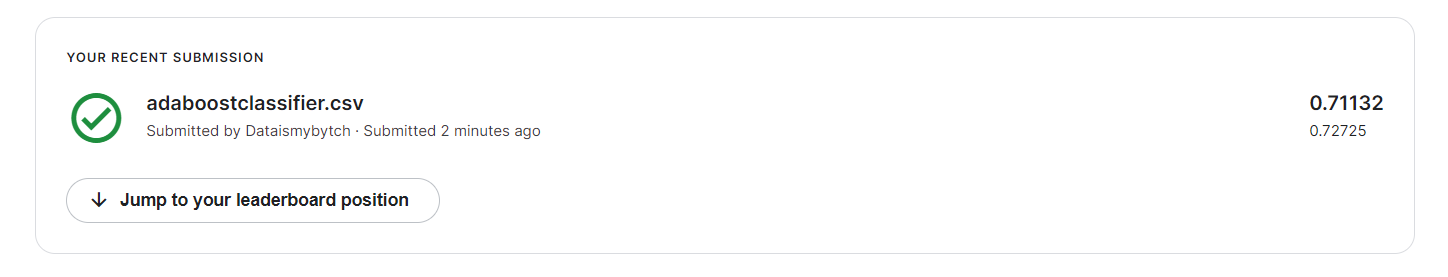

In [64]:
Image("adaKaggle.png")

In [65]:
predictions = sv_random1.predict_proba(X_test_sc)[:,1]
pred_df = pd.DataFrame({'Id': df_test_merged['Id'], 'WnvPresent': predictions})

In [66]:
pred_df.to_csv('ensemble.csv')

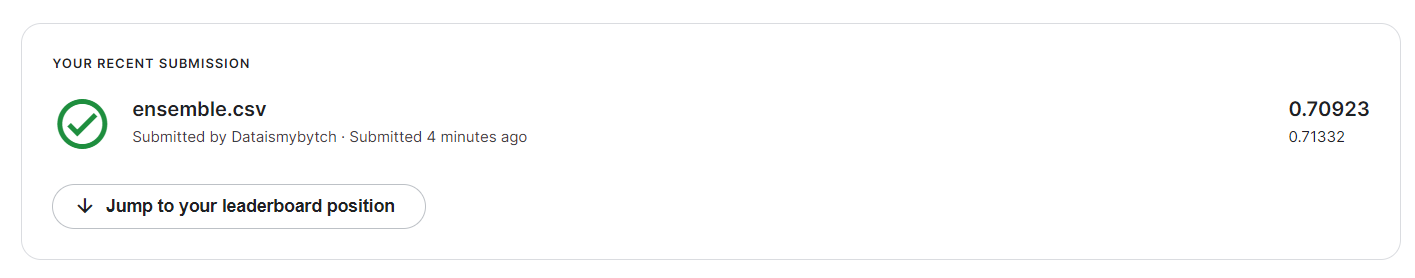

In [67]:
Image("ensembleKaggle.png")

We will achieve substantial costs savings if we target the spraying of adulticides on targeted areas based on the proximity to weather station 1. 
​
**Recommendations**
​
* ADAboost classifer gives the highest accuracy score and has significantly shortly runtime, it is, hence, our model of choice.
* Collaborate with meteorologists and researchers to further investigate the impact of weather and seasons on occurrence of WNV
* Improve data collection on pesticide sprays conducted in the city to accurately track the effectiveness of sprays in curbing the spread of WNV
* Engage with research scientists to further investigate the virus-carrying mosquito species (Culex Pipiens & Culex Restuans) to find other methods to effectively inhibit their growth and spread